# Tutorial Note
이번 이상치 탐지에서의 tutorial은 AutoEncoder를 활용한 탐지 성능에 대해 간단하게 실험해봅니다. Tutorial의 목적은 다음과 같습니다.

- naive AutoEncoder, Denoising AutoEncoder, Convolutional AutoEncoder, Convolutional Denoising AutoEncoder 구현 및 학습
- 각 모델별 MNIST 데이터셋의 하나의 클래스 이미지를 학습한 뒤, 다른 클래스 이미지를 입력했을 때의 결과 비교

먼저, 아래의 Tutorial에 앞서 각 AutoEncoder들은 .py로 구현하고 terminal 환경에서 학습을 수행했으며, 학습된 모델을 가져와 아래 내용의 Tutorial을 진행했습니다.

In [136]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from tqdm import tqdm

from AutoEncoders import Autoencoder, Denoising_Autoencoder
from Conv_AutoEncoders import Conv_Autoencoder, Conv_Denoising_Autoencoder

Test를 위한 데이터셋 불러옵니다.
- MNIST 숫자 5의 이미지
- MNIST 숫자 8의 이미지

In [2]:
# test download for inference
test_set = torchvision.datasets.MNIST(
    root = './data/MNIST',
    train = False,
    download = True,
    transform = transforms.ToTensor())

In [149]:
test_five = []
test_eight = []

for i in tqdm(range(len(test_set))):
    if test_set[i][1] == 5:
        test_five.append(test_set[i][0])
    elif test_set[i][1] == 8:
        test_eight.append(test_set[i][0])

test_five = test_five[700:]
test_five = torch.stack(test_five)
test_eight = torch.stack(test_eight)

100%|██████████| 10000/10000 [00:00<00:00, 11534.04it/s]


가져온 테스트 이미지를 시각화해보겠습니다. 임의의 데이터 5개를 뽑아 대표적으로 시각화를 수행해보았습니다.
해당 샘플 데이터들을 대상으로 학습된 AutoEncoder들을 이용해 추론한 결과와 비교해보도록 하겠습니다.

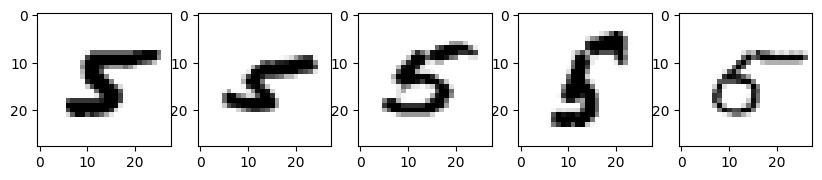

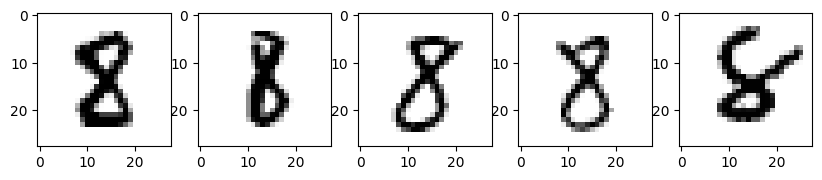

In [172]:
sample = [7, 14, 20, 27, 45]

plt.figure(figsize=(10,4))
plt.subplot(1, 5, 1)
plt.imshow(test_five[sample[0]].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 2)
plt.imshow(test_five[sample[1]].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 3)
plt.imshow(test_five[sample[2]].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 4)
plt.imshow(test_five[sample[3]].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 5)
plt.imshow(test_five[sample[4]].reshape(28,28), cmap=plt.cm.gray_r)

plt.figure(figsize=(10,4))
plt.subplot(1, 5, 1)
plt.imshow(test_eight[sample[0]].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 2)
plt.imshow(test_eight[sample[1]].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 3)
plt.imshow(test_eight[sample[2]].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 4)
plt.imshow(test_eight[sample[3]].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 5)
plt.imshow(test_eight[sample[4]].reshape(28,28), cmap=plt.cm.gray_r)
plt.show()

## 1. AutoEncoder
학습한 모델의 마지막 epoch에 저장된 가중치들을 가져와 추론에 사용했습니다.

In [101]:
model_AE = Autoencoder()
model_AE.load_state_dict(torch.load("./save_AE/ae_300.pth"))
model_AE.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=32, out_features=16, bias=True)
    (16): ReLU()
  )
  (decoder): Sequential(
    (0): Linear

앞서 선정한 샘플 데이터들에 대해 추론을 수행한 뒤, 시각화해보았습니다. 시각화의 첫번째 행은 같은 class인 숫자 5를 입력했을 경우 복원한 이미지이며, 두번째 행은 숫자 8에 대한 이미지를 입력했을 경우의 복원 결과입니다. 5에 대해서만 학습했기 때문에 완벽하게 8로 복원하지 못하고 있음을 확인할 수 있습니다.

In [173]:
result_from_AE = []
for i in sample:
    images = test_five[i].unsqueeze_(0)
    images = images.view(-1, 28*28)
    with torch.no_grad():
        _, decoded = model_AE(images)
        result_from_AE.append(decoded)

for i in sample:
    images = test_eight[i].unsqueeze_(0)
    images = images.view(-1, 28*28)
    with torch.no_grad():
        _, decoded = model_AE(images)
        result_from_AE.append(decoded)

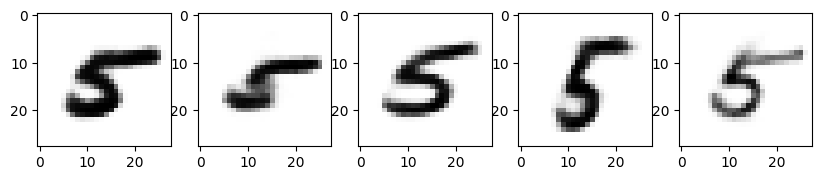

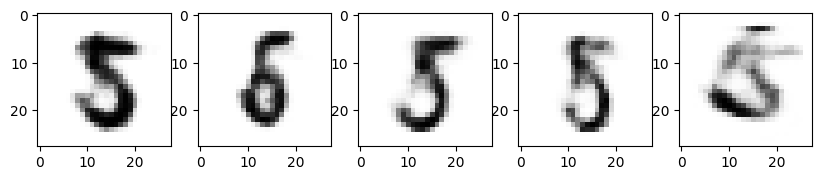

In [174]:
plt.figure(figsize=(10,4))
plt.subplot(1, 5, 1)
plt.imshow(result_from_AE[0].reshape(28,28,1), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 2)
plt.imshow(result_from_AE[1].reshape(28,28,1), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 3)
plt.imshow(result_from_AE[2].reshape(28,28,1), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 4)
plt.imshow(result_from_AE[3].reshape(28,28,1), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 5)
plt.imshow(result_from_AE[4].reshape(28,28,1), cmap=plt.cm.gray_r)

plt.figure(figsize=(10,4))
plt.subplot(1, 5, 1)
plt.imshow(result_from_AE[5].reshape(28,28,1), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 2)
plt.imshow(result_from_AE[6].reshape(28,28,1), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 3)
plt.imshow(result_from_AE[7].reshape(28,28,1), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 4)
plt.imshow(result_from_AE[8].reshape(28,28,1), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 5)
plt.imshow(result_from_AE[9].reshape(28,28,1), cmap=plt.cm.gray_r)
plt.show()

좀 더 정량적으로 확인해보기 위해, 각 픽셀값에 대해 절대적인 차이를 계산해 비교해보았습니다. 생각보다 다른 클래스의 이미지를 넣었을 때, 이를 정량적으로만 계산하면 같은 클래스를 입력했을 경우의 복원 성능과 크게 차이를 느끼지 못했습니다.

In [175]:
ae_score_five = []
ae_score_eight = []

for i in range(0, 5):
    score_f = torch.sum(torch.abs(test_five[i].reshape(28,28) - result_from_AE[i].reshape(28,28))).item()
    ae_score_five.append(score_f)
    
    score_s = torch.sum(torch.abs(test_eight[i].reshape(28,28) - result_from_AE[i+4].reshape(28,28))).item()
    ae_score_eight.append(score_s)
    

for idx, score in enumerate(ae_score_five):
    print(f'Score of Same Class Sample {idx+1}: ', score)

print('='*70)
for idx, score in enumerate(ae_score_eight):
    print(f'Score of Different Class Sample {idx+1}: ', score)

Score of Same Class Sample 1:  73.48776245117188
Score of Same Class Sample 2:  196.47410583496094
Score of Same Class Sample 3:  106.1259536743164
Score of Same Class Sample 4:  94.63241577148438
Score of Same Class Sample 5:  149.58062744140625
Score of Different Class Sample 1:  103.5946044921875
Score of Different Class Sample 2:  121.8653564453125
Score of Different Class Sample 3:  79.97097778320312
Score of Different Class Sample 4:  112.62454223632812
Score of Different Class Sample 5:  89.8310775756836


## 2. Denoising AutoEncoder
마찬가지로 학습한 모델의 마지막 epoch에 저장된 가중치들을 가져와 추론에 사용했습니다.

In [156]:
model_DAE = Denoising_Autoencoder()
model_DAE.load_state_dict(torch.load("./save_DAE/ae_300.pth"))
model_DAE.eval()

result_from_DAE = []
for i in sample:
    images = test_five[i].unsqueeze_(0)
    images = images.view(-1, 28*28)
    with torch.no_grad():
        _, decoded = model_DAE(images)
        result_from_DAE.append(decoded)
        
for i in sample:
    images = test_eight[i].unsqueeze_(0)
    images = images.view(-1, 28*28)
    with torch.no_grad():
        _, decoded = model_DAE(images)
        result_from_DAE.append(decoded)

앞서 선정한 샘플 데이터들에 대해 추론을 수행한 뒤, 시각화해보았습니다. 시각화의 첫번째 행은 같은 class인 숫자 5를 입력했을 경우 복원한 이미지이며, 두번째 행은 숫자 8에 대한 이미지를 입력했을 경우의 복원 결과입니다. 5에 대해서만 학습했기 때문에 완벽하게 8로 복원하지 못하고 있음을 확인할 수 있습니다.

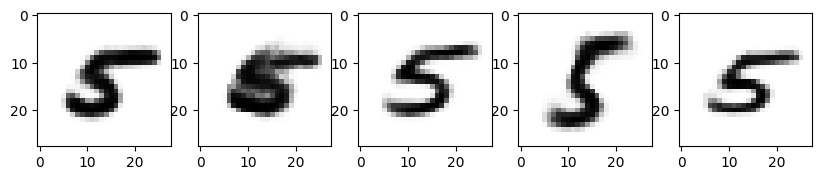

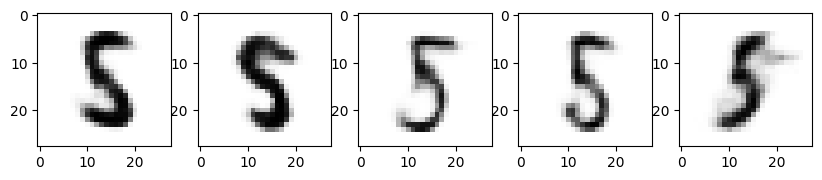

In [157]:
plt.figure(figsize=(10,4))
plt.subplot(1, 5, 1)
plt.imshow(result_from_DAE[0].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 2)
plt.imshow(result_from_DAE[1].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 3)
plt.imshow(result_from_DAE[2].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 4)
plt.imshow(result_from_DAE[3].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 5)
plt.imshow(result_from_DAE[4].reshape(28,28), cmap=plt.cm.gray_r)

plt.figure(figsize=(10,4))
plt.subplot(1, 5, 1)
plt.imshow(result_from_DAE[5].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 2)
plt.imshow(result_from_DAE[6].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 3)
plt.imshow(result_from_DAE[7].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 4)
plt.imshow(result_from_DAE[8].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 5)
plt.imshow(result_from_DAE[9].reshape(28,28), cmap=plt.cm.gray_r)
plt.show()

샘플 데이터들의 원본이미지와 복원된 이미지 사이의 정량적인 차이 결과입니다. 전반적으로 숫자만 보았을 경우에는 확연한 차이가 보이지 않습니다.

In [158]:
dae_score_five = []
ae_score_eight = []

for i in range(0, 5):
    score_f = torch.sum(torch.abs(test_five[i].reshape(28,28) - result_from_DAE[i].reshape(28,28))).item()
    dae_score_five.append(score_f)
    
    score_s = torch.sum(torch.abs(test_eight[i].reshape(28,28) - result_from_DAE[i+4].reshape(28,28))).item()
    ae_score_eight.append(score_s)
    

for idx, score in enumerate(dae_score_five):
    print(f'Score of Same Class Sample {idx+1}: ', score)

print('='*70)
for idx, score in enumerate(ae_score_eight):
    print(f'Score of Different Class Sample {idx+1}: ', score)

Score of Same Class Sample 1:  74.03855895996094
Score of Same Class Sample 2:  180.28790283203125
Score of Same Class Sample 3:  108.30550384521484
Score of Same Class Sample 4:  91.17851257324219
Score of Same Class Sample 5:  151.12396240234375
Score of Different Class Sample 1:  113.38031005859375
Score of Different Class Sample 2:  118.52909851074219
Score of Different Class Sample 3:  109.6365966796875
Score of Different Class Sample 4:  116.92364501953125
Score of Different Class Sample 5:  87.17839813232422


## 3. Convolutional AutoEncoder
Conv AE도 마찬가지로 학습한 모델의 마지막 epoch에 저장된 가중치들을 가져와 추론에 사용했습니다.

In [159]:
model_CAE = Conv_Autoencoder()
model_CAE.load_state_dict(torch.load("./save_CAE/ae_300.pth"))
model_CAE.eval()

result_from_CAE = []
for i in sample:
    images = test_five[i].unsqueeze_(0)
    with torch.no_grad():
        _, decoded = model_CAE(images)
        result_from_CAE.append(decoded)

for i in sample:
    images = test_eight[i].unsqueeze_(0)
    with torch.no_grad():
        _, decoded = model_CAE(images)
        result_from_CAE.append(decoded)

같은 샘플 데이터들에 대해 추론을 수행한 뒤, 시각화해보았습니다. 시각화의 첫번째 행은 같은 class인 숫자 5를 입력했을 경우 복원한 이미지이며, 두번째 행은 숫자 8에 대한 이미지를 입력했을 경우의 복원 결과입니다. Conv를 활용한 모델의 경우 8에 대한 이미지를 입력했을 때 8에 비슷한 복원을 어느정도 하고 있는 것이 특징입니다.

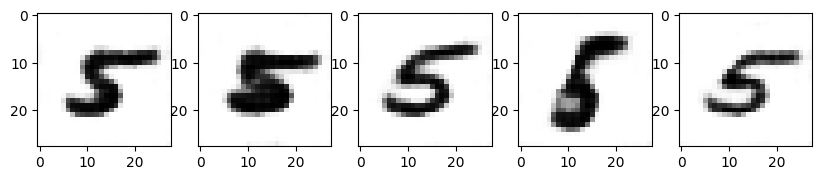

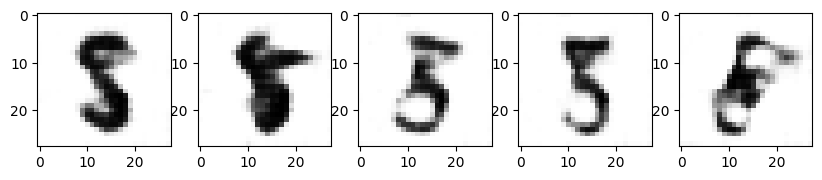

In [160]:
plt.figure(figsize=(10,4))
plt.subplot(1, 5, 1)
plt.imshow(result_from_CAE[0].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 2)
plt.imshow(result_from_CAE[1].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 3)
plt.imshow(result_from_CAE[2].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 4)
plt.imshow(result_from_CAE[3].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 5)
plt.imshow(result_from_CAE[4].reshape(28,28), cmap=plt.cm.gray_r)

plt.figure(figsize=(10,4))
plt.subplot(1, 5, 1)
plt.imshow(result_from_CAE[5].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 2)
plt.imshow(result_from_CAE[6].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 3)
plt.imshow(result_from_CAE[7].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 4)
plt.imshow(result_from_CAE[8].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 5)
plt.imshow(result_from_CAE[9].reshape(28,28), cmap=plt.cm.gray_r)
plt.show()

하지만 Conv를 활용한 AutoEncoder 역시 정량적인 평가 결과에서는 크게 차이를 관찰할 수 없었습니다. 물론, 몇몇 샘플들에서는 큰 차이가 있지만, 오히려 같은 샘플을 입력했음에도 복원이 잘 안돼 더 큰 차이가 나는 경우도 존재합니다.

In [163]:
cae_score_five = []
cae_score_eight = []

for i in range(0, 5):
    score_f = torch.sum(torch.abs(test_five[i].reshape(28,28) - result_from_CAE[i].reshape(28,28))).item()
    cae_score_five.append(score_f)
    
    score_s = torch.sum(torch.abs(test_eight[i].reshape(28,28) - result_from_CAE[i+4].reshape(28,28))).item()
    cae_score_eight.append(score_s)
    

for idx, score in enumerate(cae_score_five):
    print(f'Score of Same Class Sample {idx+1}: ', score)

print('='*70)
for idx, score in enumerate(cae_score_eight):
    print(f'Score of Different Class Sample {idx+1}: ', score)

Score of Same Class Sample 1:  74.7293930053711
Score of Same Class Sample 2:  184.88082885742188
Score of Same Class Sample 3:  106.27662658691406
Score of Same Class Sample 4:  94.38346099853516
Score of Same Class Sample 5:  150.19039916992188
Score of Different Class Sample 1:  106.1496810913086
Score of Different Class Sample 2:  125.7929916381836
Score of Different Class Sample 3:  127.45442199707031
Score of Different Class Sample 4:  102.39479064941406
Score of Different Class Sample 5:  84.0037841796875


## 4. Convolutional Denoising AutoEncoder
Conv Denoising AE도 마찬가지로 학습한 모델의 마지막 epoch에 저장된 가중치들을 가져와 추론에 사용했습니다.

In [164]:
model_CDA = Conv_Denoising_Autoencoder()
model_CDA.load_state_dict(torch.load("./save_CDAE/ae_300.pth"))
model_CDA.eval()

result_from_CDA = []
for i in sample:
    images = test_five[i].unsqueeze_(0)
    with torch.no_grad():
        _, decoded = model_CDA(images)
        result_from_CDA.append(decoded)
        
for i in sample:
    images = test_eight[i].unsqueeze_(0)
    with torch.no_grad():
        _, decoded = model_CDA(images)
        result_from_CDA.append(decoded)

앞서 선정한 샘플 데이터들에 대해 추론을 수행한 뒤, 시각화해보았습니다. 앞서 노이즈를 가하지 않은 경우보다 다른 클래스를 입력했을 때 더 잘 복원하고 있었습니다. 

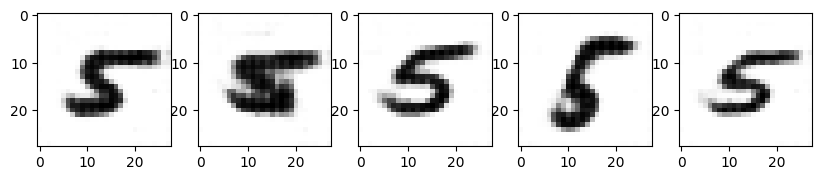

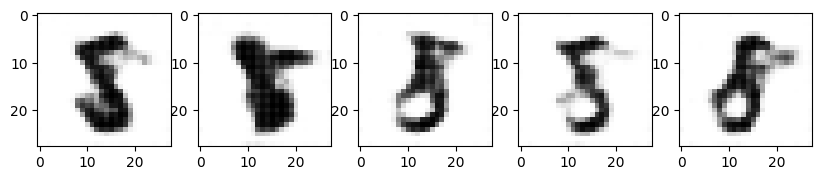

In [165]:
plt.figure(figsize=(10,4))
plt.subplot(1, 5, 1)
plt.imshow(result_from_CDA[0].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 2)
plt.imshow(result_from_CDA[1].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 3)
plt.imshow(result_from_CDA[2].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 4)
plt.imshow(result_from_CDA[3].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 5)
plt.imshow(result_from_CDA[4].reshape(28,28), cmap=plt.cm.gray_r)

plt.figure(figsize=(10,4))
plt.subplot(1, 5, 1)
plt.imshow(result_from_CDA[5].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 2)
plt.imshow(result_from_CDA[6].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 3)
plt.imshow(result_from_CDA[7].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 4)
plt.imshow(result_from_CDA[8].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplot(1, 5, 5)
plt.imshow(result_from_CDA[9].reshape(28,28), cmap=plt.cm.gray_r)
plt.show()

torch.abs(test_eight[0].reshape(28,28) - result_from_CAE[i+4].reshape(28,28))


정량적으로도 샘플마다의 편차가 커서 같은 클래스를 입력했을 때의 복원 성능과 다른 클래스를 입력했을 때의 복원 성능의 thereshold를 정하기 어려워보입니다.

In [171]:
cda_score_five = []
cda_score_eight = []

for i in range(0, 5):
    score_f = torch.sum(torch.abs(test_five[i].reshape(28,28) - result_from_CDA[i].reshape(28,28))).item()
    cda_score_five.append(score_f)
    
    score_s = torch.sum(torch.abs(test_eight[i].reshape(28,28) - result_from_CDA[i+4].reshape(28,28))).item()
    cda_score_eight.append(score_s)
    

for idx, score in enumerate(cda_score_five):
    print(f'Score of Same Class Sample {idx+1}: ', score)

print('='*70)
for idx, score in enumerate(cda_score_eight):
    print(f'Score of Different Class Sample {idx+1}: ', score)

Score of Same Class Sample 1:  71.9781723022461
Score of Same Class Sample 2:  183.72720336914062
Score of Same Class Sample 3:  105.71495819091797
Score of Same Class Sample 4:  91.36278533935547
Score of Same Class Sample 5:  150.002685546875
Score of Different Class Sample 1:  112.02201843261719
Score of Different Class Sample 2:  123.51940155029297
Score of Different Class Sample 3:  134.8317108154297
Score of Different Class Sample 4:  108.5256576538086
Score of Different Class Sample 5:  72.56718444824219
